# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')

## IMPORTAR LOS DATOS

1.- Sustituir la ruta del proyecto.

In [38]:
ruta_proyecto = 'C:/Users/pelop/OneDrive/Desktop/Curso Data Science Pedro/2 CURSO DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/03_RIESGOS'

2.- Nombrar los ficheros de datos.

In [39]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [40]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

Modificar con scikit learn:

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo PD

Crear la target a partir de estado

In [41]:
cat.estado.value_counts()

estado
Fully Paid                                             66392
Current                                                54005
Charged Off                                            16388
Late (31-120 days)                                      1332
In Grace Period                                          536
Late (16-30 days)                                        259
Does not meet the credit policy. Status:Fully Paid       108
Does not meet the credit policy. Status:Charged Off       58
Default                                                    3
Name: count, dtype: int64

In [42]:
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,Current,0
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,desconocido,debt_consolidation,36 months,Charged Off,1
46641215,Banker,5 years,Verified,A,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,desconocido,credit_card,60 months,Current,0
131289518,desconocido,10+ years,Source Verified,D,MORTGAGE,desconocido,home_improvement,60 months,Current,0
...,...,...,...,...,...,...,...,...,...,...
129396054,Field Manager,10+ years,Source Verified,D,OWN,desconocido,debt_consolidation,60 months,Current,0
119242742,desconocido,desconocido,Source Verified,C,RENT,desconocido,debt_consolidation,36 months,Late (31-120 days),0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,desconocido,other,36 months,Current,0


In [43]:
cat.drop(columns='estado',inplace=True)

### Target para el modelo EAD

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [44]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49


In [45]:
num['target_ead'] = num.pendiente / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149


### Target para el modelo LGD

Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [46]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,NaN
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Los nulos se producen cuando el pendiente es cero. Por tanto podemos imputarlos por ceros.

In [47]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Comprobamos las targets creadas.

In [48]:
cat['target_pd'].mean()

0.11826921002868832

In [49]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139081.0,0.336796,0.368981,-0.000032,0.0,0.126537,0.723754,1.0
target_lgd,139081.0,0.507544,0.490382,-0.248392,0.0,0.846928,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [50]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [51]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139081.0,0.336796,0.368981,0.0,0.0,0.126537,0.723754,1.0
target_lgd,139081.0,0.507567,0.490356,0.0,0.0,0.846928,1.000000,1.0


### Resto de variables

num_meses_desde_ult_retraso

Vamos a comenzar revisando la relación con la target_pd

In [52]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [53]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']

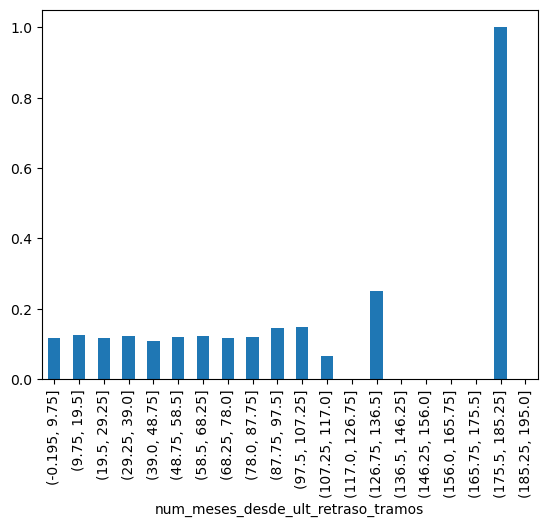

In [54]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

La distribución de la target en esta variable no nos genera confianza, así que la descartamos.

In [55]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

En vivienda juntar ANY, NONE y OTHER

In [56]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68123
RENT        55414
OWN         15471
ANY            58
OTHER          12
NONE            3
Name: count, dtype: int64

In [57]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [58]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68196
RENT        55414
OWN         15471
Name: count, dtype: int64

En finalidad juntar renewable_energy, educational y wedding en 'otros'

In [34]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    78779
credit_card           31500
home_improvement       9109
other                  8672
major_purchase         3206
medical                1681
small_business         1572
car                    1422
vacation                994
moving                  953
house                   926
wedding                 155
renewable_energy         85
educational              27
Name: count, dtype: int64

In [59]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'other')

In [60]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    78779
credit_card           31500
home_improvement       9109
other                  8939
major_purchase         3206
medical                1681
small_business         1572
car                    1422
vacation                994
moving                  953
house                   926
Name: count, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [62]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [63]:
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [64]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

#### Guardar como dataframe

In [65]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [66]:
var_oe = ['antigüedad_empleo','rating']

#### Orden de los valores de las variables

In [69]:
#Orden de la primera variable
#orden_antigüedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
#                           '5 years','6 years','7 years','8 years','9 years','10+ years']
orden_antigüedad_empleo = ['10+ years','9 years','8 years','7 years','6 years','5 years',
                           '4 years','3 years','2 years','1 year','< 1 year','desconocido']

#Orden de la segunda variable
orden_rating = ['A','B','C','D','E','F','G']

#### Instanciar

In [71]:
oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [72]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [73]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

In [74]:
cat_oe

,antigüedad_empleo_oe,rating_oe
0,7.0,0.0
1,0.0,3.0
2,5.0,0.0
3,1.0,1.0
4,0.0,3.0
...,...,...
139076,0.0,3.0
139077,11.0,2.0
139078,4.0,1.0
139079,0.0,3.0


### Fechas y textos

Cargamos stopwords y limpiamos

In [75]:
stop = pd.read_csv(ruta_proyecto + '/01_Documentos/stop_words_english.txt',names = ['termino'])

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

stop['limpias'] = stop.termino.transform(quitar_tildes)

Aplicamos tf-idf.

In [76]:
#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

#Entrenamos y aplicamos
descripcion = tfidf.fit_transform(cat.descripcion)

In [77]:
tfidf.vocabulary_

{'borrower': 15,
 '08': 7,
 '01': 0,
 '12': 11,
 'br': 22,
 '02': 1,
 'loan': 38,
 'br br': 24,
 'br borrower': 23,
 'br br borrower': 25,
 '11': 10,
 '14': 13,
 'credit': 31,
 'card': 26,
 'debt': 35,
 'pay': 42,
 'payment': 45,
 'cards': 28,
 'consolidate': 29,
 'payments': 46,
 'month': 40,
 'credit card': 32,
 'card debt': 27,
 'credit cards': 34,
 'credit card debt': 33,
 'pay credit': 43,
 '03': 2,
 'consolidation': 30,
 'borrower 03': 18,
 'bills': 14,
 'years': 49,
 'monthly': 41,
 'paying': 44,
 'rate': 47,
 'time': 48,
 'borrower 12': 21,
 '09': 8,
 'job': 37,
 '10': 9,
 '13': 12,
 '07': 6,
 'borrower 07': 20,
 'high': 36,
 '06': 5,
 'borrower 06': 19,
 '04': 3,
 'money': 39,
 'borrower 02': 17,
 'borrower 01': 16,
 '05': 4}

No parece que estos términos puedan generar información adicional a lo que tenemos, así que no incluiremos esta variable en los modelos.

## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [78]:
var_bin = ['num_derogatorios']

#### Instanciar

In [79]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [80]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [83]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Unificar los datasets a reescalar.

In [84]:
num_escalar = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [85]:
df_res = pd.concat([cat_oe,num_escalar], axis=1)

In [86]:
df_res

,antigüedad_empleo_oe,rating_oe,ingresos,dti,num_lineas_credito,porc_uso_revolving,principal,tipo_interes,imp_cuota
0,7.0,0.0,54000.0,19.31,10.0,45.2,15000.0,7.21,464.60
1,0.0,3.0,65000.0,25.40,15.0,86.2,10000.0,17.77,360.38
2,5.0,0.0,135000.0,14.68,19.0,16.3,24000.0,6.39,734.38
3,1.0,1.0,188000.0,11.69,15.0,3.3,27000.0,8.99,560.35
4,0.0,3.0,72777.0,24.74,10.0,63.2,25000.0,21.85,688.35
...,...,...,...,...,...,...,...,...,...
139076,0.0,3.0,55000.0,15.36,7.0,81.7,14400.0,17.47,361.53
139077,11.0,2.0,20000.0,8.02,5.0,33.2,2500.0,12.62,83.78
139078,4.0,1.0,111697.0,16.63,10.0,26.3,10000.0,9.44,320.05
139079,0.0,3.0,285000.0,6.02,9.0,21.1,30000.0,17.47,1076.62


#### Variables a reescalar con Min-Max

In [87]:
var_mms = df_res.columns

#### Instanciar

In [88]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [89]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [90]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

In [92]:
df_mms.describe().T

,count,mean,std,min,25%,50%,75%,max
antigüedad_empleo_oe_mms,139081.0,0.411206,0.361612,0.0,0.000000,0.454545,0.727273,1.0
rating_oe_mms,139081.0,0.277509,0.210008,0.0,0.166667,0.333333,0.333333,1.0
ingresos_mms,139081.0,0.250587,0.141145,0.0,0.153333,0.216667,0.306667,1.0
dti_mms,139081.0,0.186744,0.096619,0.0,0.119800,0.178200,0.244800,1.0
num_lineas_credito_mms,139081.0,0.127557,0.061852,0.0,0.087912,0.120879,0.153846,1.0
porc_uso_revolving_mms,139081.0,0.503290,0.246560,0.0,0.317000,0.504000,0.693000,1.0
principal_mms,139081.0,0.358336,0.234141,0.0,0.179487,0.302564,0.487179,1.0
tipo_interes_mms,139081.0,0.303101,0.188282,0.0,0.162773,0.284657,0.415888,1.0
imp_cuota_mms,139081.0,0.255736,0.155675,0.0,0.142624,0.216623,0.340735,1.0


## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [93]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [94]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [95]:
df_pd.set_index('id_cliente',inplace=True)

In [96]:
df_pd

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,vivienda_MORTGAGE,vivienda_OWN,vivienda_RENT,finalidad_car,finalidad_credit_card,finalidad_debt_consolidation,finalidad_home_improvement,...,rating_oe_mms,ingresos_mms,dti_mms,num_lineas_credito_mms,porc_uso_revolving_mms,principal_mms,tipo_interes_mms,imp_cuota_mms,num_derogatorios_bin,target_pd
id_cliente,,,,,,,,,,,,,,,,,,,,,
137387967,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.180000,0.1931,0.109890,0.452,0.358974,0.073988,0.267726,0.0,0
4798121,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.500000,0.216667,0.2540,0.164835,0.862,0.230769,0.485202,0.206669,0.0,1
46641215,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.450000,0.1468,0.208791,0.163,0.589744,0.042056,0.425776,0.0,0
87998444,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.166667,0.626667,0.1169,0.164835,0.033,0.666667,0.143302,0.323821,0.0,0
131289518,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.500000,0.242590,0.2474,0.109890,0.632,0.615385,0.644081,0.398810,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.500000,0.183333,0.1536,0.076923,0.817,0.343590,0.473520,0.207343,0.0,0
119242742,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.066667,0.0802,0.054945,0.332,0.038462,0.284657,0.044624,0.0,0
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.1663,0.109890,0.263,0.230769,0.160826,0.183042,1.0,0


### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [97]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [98]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [99]:
df_ead.set_index('id_cliente',inplace=True)

In [100]:
df_ead

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,vivienda_MORTGAGE,vivienda_OWN,vivienda_RENT,finalidad_car,finalidad_credit_card,finalidad_debt_consolidation,finalidad_home_improvement,...,rating_oe_mms,ingresos_mms,dti_mms,num_lineas_credito_mms,porc_uso_revolving_mms,principal_mms,tipo_interes_mms,imp_cuota_mms,num_derogatorios_bin,target_ead
id_cliente,,,,,,,,,,,,,,,,,,,,,
137387967,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.180000,0.1931,0.109890,0.452,0.358974,0.073988,0.267726,0.0,0.822063
4798121,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.500000,0.216667,0.2540,0.164835,0.862,0.230769,0.485202,0.206669,0.0,0.363704
46641215,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.450000,0.1468,0.208791,0.163,0.589744,0.042056,0.425776,0.0,0.000000
87998444,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.166667,0.626667,0.1169,0.164835,0.033,0.666667,0.143302,0.323821,0.0,0.539148
131289518,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.500000,0.242590,0.2474,0.109890,0.632,0.615385,0.644081,0.398810,0.0,0.887549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.500000,0.183333,0.1536,0.076923,0.817,0.343590,0.473520,0.207343,0.0,0.862782
119242742,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.066667,0.0802,0.054945,0.332,0.038462,0.284657,0.044624,0.0,0.601576
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.1663,0.109890,0.263,0.230769,0.160826,0.183042,1.0,0.561149


### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [101]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [102]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [103]:
df_lgd.set_index('id_cliente',inplace=True)

In [104]:
df_lgd

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,vivienda_MORTGAGE,vivienda_OWN,vivienda_RENT,finalidad_car,finalidad_credit_card,finalidad_debt_consolidation,finalidad_home_improvement,...,rating_oe_mms,ingresos_mms,dti_mms,num_lineas_credito_mms,porc_uso_revolving_mms,principal_mms,tipo_interes_mms,imp_cuota_mms,num_derogatorios_bin,target_lgd
id_cliente,,,,,,,,,,,,,,,,,,,,,
137387967,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.180000,0.1931,0.109890,0.452,0.358974,0.073988,0.267726,0.0,1.000000
4798121,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.500000,0.216667,0.2540,0.164835,0.862,0.230769,0.485202,0.206669,0.0,1.000000
46641215,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.450000,0.1468,0.208791,0.163,0.589744,0.042056,0.425776,0.0,0.000000
87998444,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.166667,0.626667,0.1169,0.164835,0.033,0.666667,0.143302,0.323821,0.0,1.000000
131289518,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.500000,0.242590,0.2474,0.109890,0.632,0.615385,0.644081,0.398810,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.500000,0.183333,0.1536,0.076923,0.817,0.343590,0.473520,0.207343,0.0,1.000000
119242742,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.066667,0.0802,0.054945,0.332,0.038462,0.284657,0.044624,0.0,1.000000
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.1663,0.109890,0.263,0.230769,0.160826,0.183042,1.0,1.000000


## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [105]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [107]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)